**Install Dependencies**

In [1]:
# %%capture
# !pip install -U fastai diffusers transformers jupyter huggingface-hub;

**Check diffusers version**

In [2]:
import diffusers
diffusers.__version__

'0.7.1'

**Import dependencies**

In [3]:
from pathlib import Path
import hashlib
import json

import logging
logging.disable(logging.WARNING)

from PIL import Image
import numpy as np
import torch

import pandas as pd
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler, EulerDiscreteScheduler

from tqdm.auto import tqdm

from fastdownload import FastDownload

**Log into Hugging Face Hub**

1. Generate a user access token: [Access Tokens](https://huggingface.co/settings/tokens)
2. Paste your token when prompted after running the code cell below.

In [4]:
from huggingface_hub import notebook_login
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

**Verify cached token**

In [5]:
!ls ~/.huggingface

token


**Accept Model License**

The Stable Diffusion checkpoints are available under the [CreativeML OpenRail-M license](https://huggingface.co/spaces/CompVis/stable-diffusion-license). The license claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. Open the Model Card pages below and accept the license agreement to download the pretrained models.. 


If you do accept the license, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work. You have two options to provide your access token:

* [**Stable Diffusion v1-4 Model Card**](https://huggingface.co/CompVis/stable-diffusion-v1-4)
* [**Stable Diffusion v1-5 Model Card**](https://huggingface.co/runwayml/stable-diffusion-v1-5)

**Select a model**

In [6]:
# model_name = "CompVis/stable-diffusion-v1-4"
model_name = "runwayml/stable-diffusion-v1-5"

**Load autoencoder**

In [7]:
vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae", torch_dtype=torch.float16).to("cuda")

# vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16).to("cuda")
# vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")

**Load unet**

In [8]:
unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet", torch_dtype=torch.float16).to("cuda")

**Select a CLIP model**

In [9]:
clip_name = "openai/clip-vit-large-patch14"

**Load tokenizer**

In [10]:
tokenizer = CLIPTokenizer.from_pretrained(clip_name, torch_dtype=torch.float16)

**Load text encoder**

In [11]:
text_encoder = CLIPTextModel.from_pretrained(clip_name, torch_dtype=torch.float16).to("cuda")

**Define source of custom embedding**
* **[birb-style Model Card](https://huggingface.co/sd-concepts-library/birb-style)**

In [12]:
embeds_url = "https://huggingface.co/sd-concepts-library/birb-style/resolve/main/learned_embeds.bin"
embeds_url

'https://huggingface.co/sd-concepts-library/birb-style/resolve/main/learned_embeds.bin'

**Download custom embedding**

In [13]:
embeds_path = FastDownload().download(embeds_url, force=True)

**Verify download**

In [14]:
!ls *.bin

learned_embeds.bin


**Load custom embedding**

In [15]:
embeds_dict = torch.load(embeds_path, map_location="cpu")
embeds_dict.keys()

dict_keys(['<birb-style>'])

**Add custom token**

In [16]:
new_token, embeds = next(iter(embeds_dict.items()))
embeds = embeds.to(text_encoder.dtype)
tokenizer.add_tokens(new_token)
text_encoder.resize_token_embeddings(len(tokenizer))
new_token_id = tokenizer.convert_tokens_to_ids(new_token)
text_encoder.get_input_embeddings().weight.data[new_token_id] = embeds
new_token

'<birb-style>'

**Define noise scheduler**

In [17]:
# scheduler = LMSDiscreteScheduler(beta_start=0.00085, 
#                                  beta_end=0.012, 
#                                  beta_schedule="scaled_linear", 
#                                  num_train_timesteps=1000)

In [18]:
scheduler = EulerDiscreteScheduler.from_config("runwayml/stable-diffusion-v1-5", subfolder="scheduler")

**Define method to tokenizer and encode text**

In [19]:
def text_enc(prompts, maxlen=None):
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt")
    return text_encoder(inp.input_ids.to("cuda"))[0].half()

**Define method to convert output tensor to image**

In [20]:
def tensor_to_img(tensor):
    image = (tensor/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()
    return Image.fromarray((image*255).round().astype("uint8"))

**Define method to save image with unique file name**

In [21]:
def save_img(image, save_dir, fmt='PNG'):
    img_hash = hashlib.sha256(np.array(image)).hexdigest()[:24]
    image.save(f"{save_dir}/{img_hash}.{fmt.lower()}", format=fmt)
    return img_hash

**Define method to pipeline config used to generate an image**

In [22]:
def save_pipe_config(img_name, pipe_config, save_dir):
    with open(f"{save_dir}/{img_name}.json", "w") as write_file:
        json.dump(pipe_config, write_file)

**Define method to perform text2img generation**

In [23]:
def generate_text2img(prompt, negative_prompt="", height=512, width=512, g=0.15, steps=70, generator=None):

    # Encode text prompt
    text = text_enc(prompt)
    # Encode negative prompt
    uncond = text_enc(negative_prompt, text.shape[1])
    # Concatenate encoded prompts
    emb = torch.cat([uncond, text])
    
    # Initialize noisy latents
    latents_shape = (1, unet.in_channels, height//8, width//8)
    latents = torch.randn(latents_shape, generator=generator, device='cuda', dtype=emb.dtype)
    
    # Set number of time steps for diffusion process
    scheduler.set_timesteps(steps)
    # Scale noisy latents
    latents = latents.to("cuda").half() * scheduler.init_noise_sigma

    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        # Scale latents
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        # Get model output
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
        
        # Rescale guidance
        # https://forums.fast.ai/t/lesson-10-official-topic/101171/101
        pred_nonscaled= u + g*(t-u)/torch.norm(t-u)*torch.norm(u)
        pred = pred_nonscaled * torch.norm(u)/torch.norm(pred_nonscaled)
        
        # Update latents
        latents = scheduler.step(pred, ts, latents).prev_sample
        
        # Releases all unoccupied cached memory
        torch.cuda.empty_cache()
    
    # Decode output tensor
    with torch.no_grad(): return vae.decode(1 / 0.18215 * latents).sample

**Define text prompt**

In [24]:
prompt = f"A professional digital painting of a robot giving a thumbs up in the style of {new_token}, gorgeous digital painting, warm colors, captivating, trending in artstation"
prompt

'A professional digital painting of a robot giving a thumbs up in the style of <birb-style>, gorgeous digital painting, warm colors, captivating, trending in artstation'

**Define negative prompt**

In [25]:
negative_prompt = "lowres, bad, error, blurry, compressed, incomplete"
negative_prompt

'lowres, bad, error, blurry, compressed, incomplete'

**Initialize random number generator for consistent images**

In [26]:
generator = torch.Generator(device='cuda')
generator.manual_seed(100);
# generator.manual_seed(789890158);
# generator.manual_seed(1);

**Define pipe config**

In [27]:
pipe_config = {}
pipe_config['model'] = model_name
pipe_config['prompt'] = prompt
pipe_config['negative_prompt'] = negative_prompt
pipe_config['height'] = 512
pipe_config['width'] = 512
pipe_config['steps'] = 70
pipe_config['guidance'] = 0.2
pipe_config['init_seed'] = generator.initial_seed()
pipe_config['generator_state'] = [int(i) for i in generator.get_state()]
pd.DataFrame.from_dict(pipe_config, orient='index')

,0
model,runwayml/stable-diffusion-v1-5
prompt,"A professional digital painting of a robot giving a thumbs up in the style of <birb-style>, gorgeous digital painting, warm colors, captivating, trending in artstation"
negative_prompt,"lowres, bad, error, blurry, compressed, incomplete"
height,512
width,512
steps,70
guidance,0.2
init_seed,100
generator_state,"[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, ...]"


**Optional: Load a config file to recreate a specific image**

In [28]:
# config_path = Path("../pipe_configs/cc96ce4ebb4b8ddfed9a7235.json")

In [29]:
# with open(config_path) as f:
#     pipe_config = json.load(f)
#     generator_state = torch.tensor(pipe_config['generator_state'], dtype=torch.uint8)
#     generator.manual_seed(pipe_config['init_seed'])
#     generator.set_state(generator_state)
# pd.DataFrame.from_dict(pipe_config, orient='index')

**Define method that returns a stack of images**

In [30]:
def stack_imgs(imgs):
    w,h = imgs[0].size
    stack = Image.new('RGB', size=(w, len(imgs)*h))
    for i, img in enumerate(imgs): stack.paste(img, box=(0, i*h, w, (i+1)*h))
    return stack

**Define directory to store generated images**

In [31]:
output_dir = Path("./output_dir")
output_dir.mkdir(parents=True, exist_ok=True)
output_dir

Path('output_dir')

**Specify number of images to generate**

In [32]:
num_images = 1

**Generate images**

  0%|          | 0/70 [00:00<?, ?it/s]

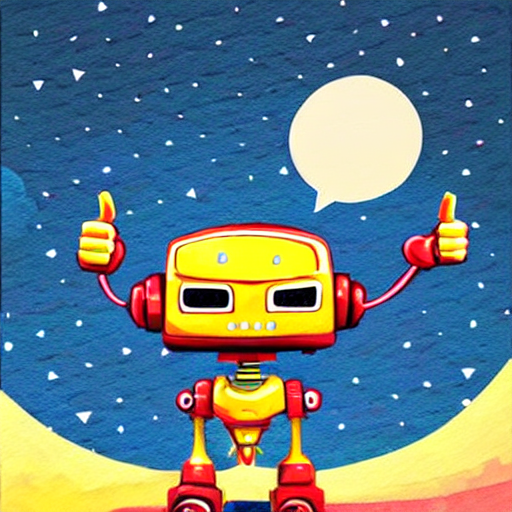

In [33]:
all_images = []
generator_states = []

for i in range(num_images):
    img_tensors = generate_text2img(prompt=pipe_config['prompt'], 
                                    negative_prompt=pipe_config['negative_prompt'],
                                    height=pipe_config['height'],
                                    width=pipe_config['width'], 
                                    g=pipe_config['guidance'], 
                                    steps=pipe_config['steps'], 
                                    generator=generator)
    generator_states.append([int(i) for i in generator.get_state()])
    all_images.extend([tensor_to_img(t) for t in img_tensors])
    torch.cuda.empty_cache()
    
for i, image in enumerate(all_images):
    img_name = save_img(image, save_dir=output_dir)
    save_pipe_config(img_name=img_name, pipe_config=pipe_config, save_dir=output_dir)
    pipe_config['generator_state'] = generator_states[i]

stack_imgs(all_images)